In [1]:
# prompt: Mount and cd to this directory

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS608

Mounted at /content/drive
/content/drive/My Drive/CS608


## Visual Similarity Analysis

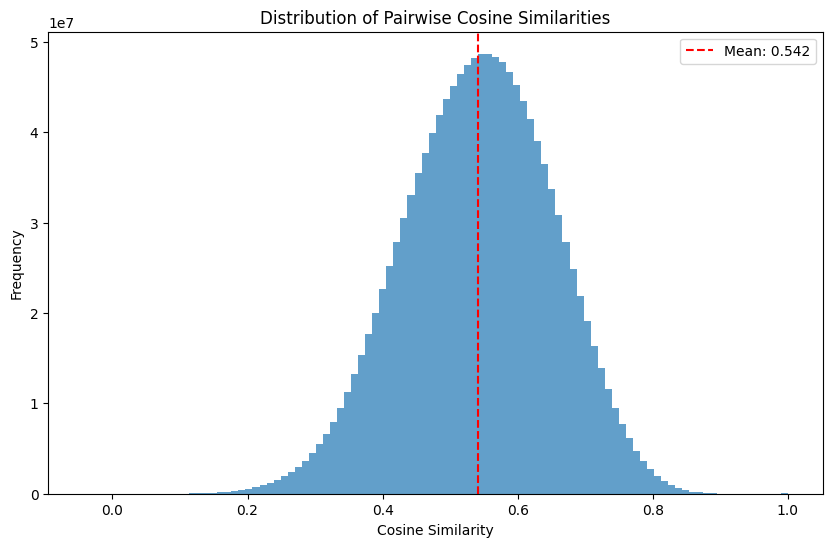

Mean similarity: 0.542
Std similarity: 0.110
Min similarity: -0.043
Max similarity: 1.000


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO

# Load your embeddings
item_image_features = np.load('RN50_item_image_features.npy', allow_pickle=True).item()

# Convert to arrays for analysis
item_ids = list(item_image_features.keys())
embeddings_matrix = np.vstack([item_image_features[iid] for iid in item_ids])

# Normalize embeddings
from sklearn.preprocessing import normalize
embeddings_normalized = normalize(embeddings_matrix, norm='l2', axis=1)

# 1. Compute pairwise similarities
similarities = cosine_similarity(embeddings_normalized)

# Analyze similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similarities.flatten(), bins=100, alpha=0.7)
plt.title('Distribution of Pairwise Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.axvline(x=similarities.mean(), color='r', linestyle='--', label=f'Mean: {similarities.mean():.3f}')
plt.legend()
plt.show()

print(f"Mean similarity: {similarities.mean():.3f}")
print(f"Std similarity: {similarities.std():.3f}")
print(f"Min similarity: {similarities.min():.3f}")
print(f"Max similarity: {similarities.max():.3f}")

## t-sne visualisation

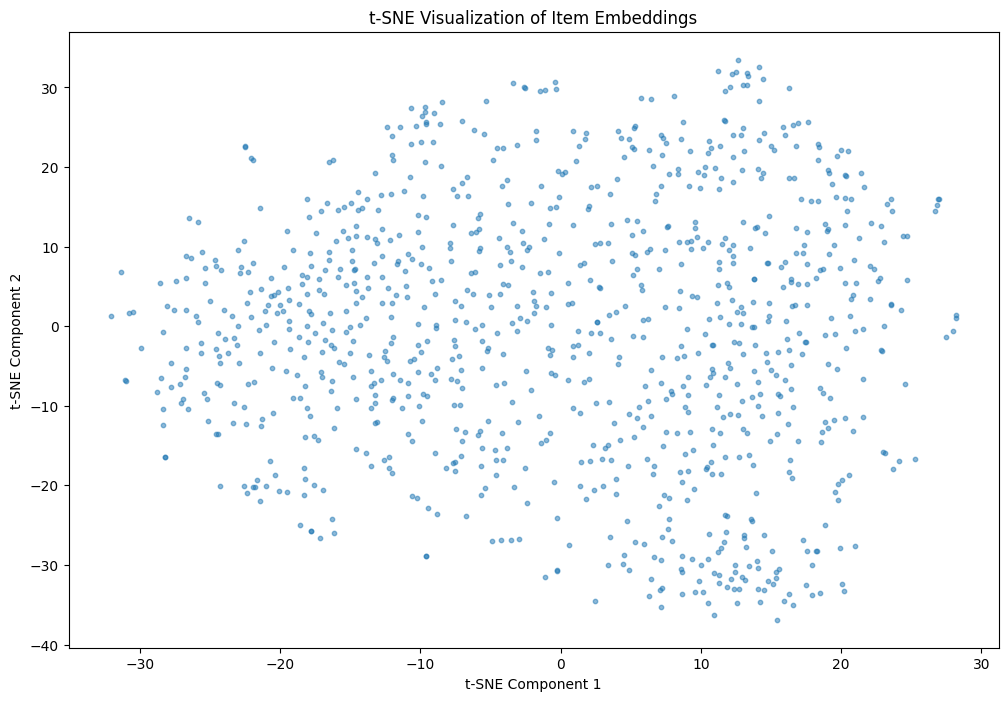

In [3]:
# Sample a subset for visualization (t-SNE is computationally expensive)
n_samples = min(1000, len(embeddings_normalized))
sample_indices = np.random.choice(len(embeddings_normalized), n_samples, replace=False)
sample_embeddings = embeddings_normalized[sample_indices]
sample_ids = [item_ids[i] for i in sample_indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, s=10)
plt.title('t-SNE Visualization of Item Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Find and visualise nearest neighbours

In [4]:
def find_nearest_neighbors(item_idx, embeddings, k=5):
    """Find k nearest neighbors for a given item"""
    similarities = cosine_similarity([embeddings[item_idx]], embeddings)[0]
    # Exclude the item itself
    similarities[item_idx] = -1
    nearest_indices = np.argsort(similarities)[::-1][:k]
    return nearest_indices, similarities[nearest_indices]

# If you have access to item metadata (titles, images, etc.)
# You'll need to load this separately based on your data
def display_item_info(item_id):
    """Display item information - customize based on your data"""
    print(f"Item ID: {item_id}")
    # Add code to display image/title if available

# Analyze random items
n_examples = 5
random_indices = np.random.choice(len(embeddings_normalized), n_examples, replace=False)

for idx in random_indices:
    print(f"\n{'='*50}")
    print(f"Query Item: {item_ids[idx]}")
    display_item_info(item_ids[idx])

    neighbors, similarities = find_nearest_neighbors(idx, embeddings_normalized)
    print(f"\nNearest Neighbors:")
    for i, (neighbor_idx, sim) in enumerate(zip(neighbors, similarities)):
        print(f"{i+1}. Item {item_ids[neighbor_idx]} - Similarity: {sim:.3f}")
        display_item_info(item_ids[neighbor_idx])


Query Item: 926860
Item ID: 926860

Nearest Neighbors:
1. Item 1605430 - Similarity: 0.873
Item ID: 1605430
2. Item 2091500 - Similarity: 0.870
Item ID: 2091500
3. Item 1149940 - Similarity: 0.865
Item ID: 1149940
4. Item 1907900 - Similarity: 0.863
Item ID: 1907900
5. Item 1204370 - Similarity: 0.862
Item ID: 1204370

Query Item: 1052380
Item ID: 1052380

Nearest Neighbors:
1. Item 506150 - Similarity: 0.887
Item ID: 506150
2. Item 765060 - Similarity: 0.880
Item ID: 765060
3. Item 386340 - Similarity: 0.874
Item ID: 386340
4. Item 1175460 - Similarity: 0.872
Item ID: 1175460
5. Item 456830 - Similarity: 0.871
Item ID: 456830

Query Item: 1677260
Item ID: 1677260

Nearest Neighbors:
1. Item 1492990 - Similarity: 0.777
Item ID: 1492990
2. Item 1282500 - Similarity: 0.775
Item ID: 1282500
3. Item 1422950 - Similarity: 0.766
Item ID: 1422950
4. Item 923880 - Similarity: 0.761
Item ID: 923880
5. Item 1977530 - Similarity: 0.760
Item ID: 1977530

Query Item: 1965610
Item ID: 1965610

Near

## Embedding Quality Metrics

In [5]:
# 1. Average distance to k-nearest neighbors
def avg_knn_distance(embeddings, k=10):
    """Calculate average distance to k nearest neighbors"""
    distances = []
    for i in range(len(embeddings)):
        sims = cosine_similarity([embeddings[i]], embeddings)[0]
        sims[i] = -1  # Exclude self
        knn_sims = np.sort(sims)[::-1][:k]
        avg_dist = 1 - np.mean(knn_sims)  # Convert similarity to distance
        distances.append(avg_dist)
    return np.mean(distances)

# 2. Intrinsic dimensionality estimate
def estimate_intrinsic_dim(embeddings, k=10):
    """Estimate intrinsic dimensionality using MLE"""
    n = len(embeddings)
    dims = []

    for i in range(n):
        dists = np.linalg.norm(embeddings - embeddings[i], axis=1)
        dists[i] = np.inf  # Exclude self
        knn_dists = np.sort(dists)[:k]

        # MLE estimate
        if knn_dists[-1] > 0:
            dim = k / np.sum(np.log(knn_dists[-1] / knn_dists[:-1]))
            dims.append(dim)

    return np.median(dims)

avg_knn_dist = avg_knn_distance(embeddings_normalized)
intrinsic_dim = estimate_intrinsic_dim(embeddings_normalized)

print(f"Average k-NN distance: {avg_knn_dist:.3f}")
print(f"Estimated intrinsic dimensionality: {intrinsic_dim:.1f}")
print(f"Embedding dimensionality: {embeddings_normalized.shape[1]}")

KeyboardInterrupt: 